## Import libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

In [3]:
import os

## Load data

In [4]:
predictions = pd.read_csv('predictions_cnn.csv')
predictions

img_path  frame  label  pred_label  \
0     /content/clasico_frames/frame27250.jpg  27250      1           0   
1     /content/clasico_frames/frame27260.jpg  27260      1           0   
2     /content/clasico_frames/frame27270.jpg  27270      1           1   
3     /content/clasico_frames/frame27280.jpg  27280      1           0   
4     /content/clasico_frames/frame27290.jpg  27290      1           2   
...                                      ...    ...    ...         ...   
5853  /content/clasico_frames/frame85780.jpg  85780      3           0   
5854  /content/clasico_frames/frame85790.jpg  85790      3           3   
5855  /content/clasico_frames/frame85800.jpg  85800      3           3   
5856  /content/clasico_frames/frame85810.jpg  85810      3           3   
5857  /content/clasico_frames/frame85820.jpg  85820      3           3   

      confidence  
0       0.851303  
1       0.879458  
2       0.999316  
3       0.572468  
4       0.968415  
...          ...  
5853    0.936655  
5854    0.999839  
5855    0.999843  
5856    0.989938  
5857    0.986211  

[5858 rows x 5 columns]

In [5]:
def get_human_label(label):
    if label == 0:
        return('death ball')
    elif label == 1:
        return('real madrid')
    elif label == 2:
        return('barcelona')
    elif label == 3:
        return('replay')

In [6]:
pred_labels = pd.Series(map(get_human_label, predictions['pred_label']))
labels = pd.Series(map(get_human_label, predictions['label']))

## Let's analyze labels vs predictions

### Distribution

In [7]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

pred         barcelona  death ball  real madrid    replay       All
label                                                              
barcelona     0.180096    0.027654     0.120178  0.006316  0.334244
death ball    0.033629    0.134175     0.046432  0.033629  0.247866
real madrid   0.096961    0.010072     0.104814  0.004950  0.216798
replay        0.022704    0.036190     0.009389  0.132810  0.201093
All           0.333390    0.208091     0.280813  0.177706  1.000000

### Recall

In [8]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

pred         barcelona  death ball  real madrid    replay
label                                                    
barcelona     0.538815    0.082737     0.359551  0.018897
death ball    0.135675    0.541322     0.187328  0.135675
real madrid   0.447244    0.046457     0.483465  0.022835
replay        0.112903    0.179966     0.046689  0.660441

### Precision

In [9]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

pred         barcelona  death ball  real madrid    replay
label                                                    
barcelona     0.540195    0.132896     0.427964  0.035543
death ball    0.100870    0.644791     0.165350  0.189241
real madrid   0.290835    0.048400     0.373252  0.027858
replay        0.068100    0.173913     0.033435  0.747358

The algorithm is proving to be good to differentiate _replays_ from the other labels since it has the better recall and precision. One reason can be that the camera angle is normally different than the one that shows the live-game.  

In second place regarding both metrics we have the _death ball_. The reason can be similar since many times the camera shows close-ups to specific players or to the managers. 

Consequently, it seems the algorithm usually figures out when the ball is in play. However, it still struggles to understand who has the possession of it.

## How can we differentiate better each label?

### Top 5 surprising mistakes

In [10]:
surprising_mistakes = predictions[predictions['label'] != predictions['pred_label']]\
                                 .sort_values('confidence', ascending = False)\
                                 .head(5)

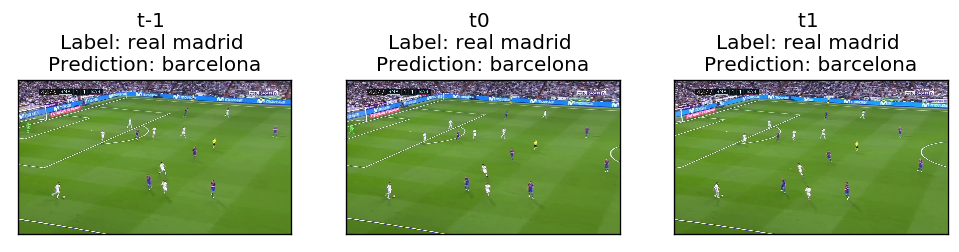

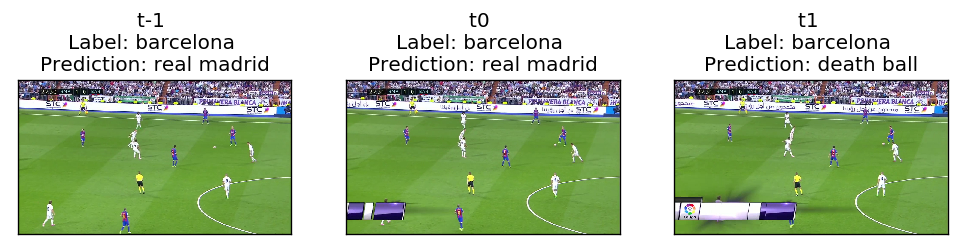

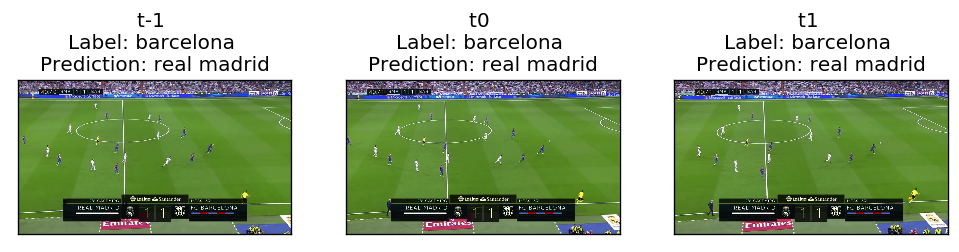

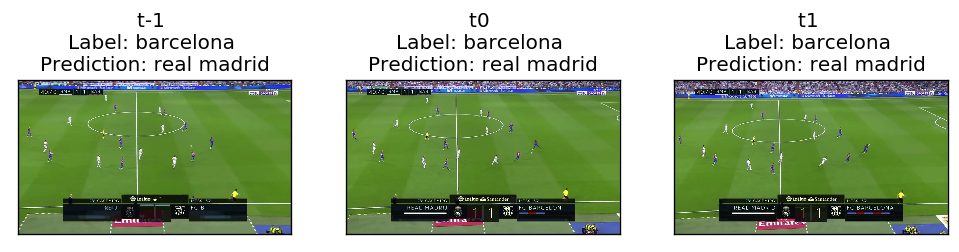

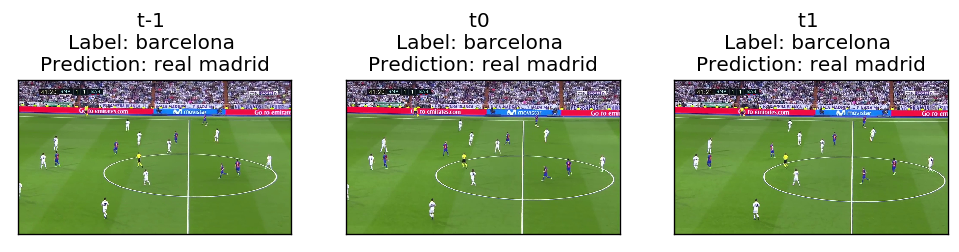

In [11]:
for index, row in surprising_mistakes.iterrows():
    frame = row['frame']
    label = get_human_label(row['label'])
    prediction = get_human_label(row['pred_label'])
    
    fig, axes = plt.subplots(1, 3, figsize=(10,4), dpi=120)
    plt.gca().clear()
    
    i = 0
    for k in [-1, 0, 1]:
        frame_ = frame + 10*k
        label = get_human_label(list(predictions['label'][predictions['frame'] == frame_])[0])
        prediction = get_human_label(list(predictions['pred_label'][predictions['frame'] == frame_])[0])
        img_path = os.path.join("../ExtractFrames/", "clasico_frames/frame%s.jpg" % (frame_))
        axes[i].imshow(mpimg.imread(img_path))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title('t%d \nLabel: %s \nPrediction: %s' %(k, label, prediction))
        i += 1
    
    plt.show()      

In almost all these cases, it seems easy for the human eye to find who has the possession. Moreover, when we consider the previous and posterior frame it seems we can even guess how the ball is being moved. However, we can notice that the algorithm is failing for the three images.

It seems like the network is considering things different from the ball to guess the label. For instance, it can be taking into account the part of the field where the ball is being played or the body position.

### Uncertainity

In [12]:
uncertainity = predictions.sort_values('confidence', ascending = False)\
                          .head(5)

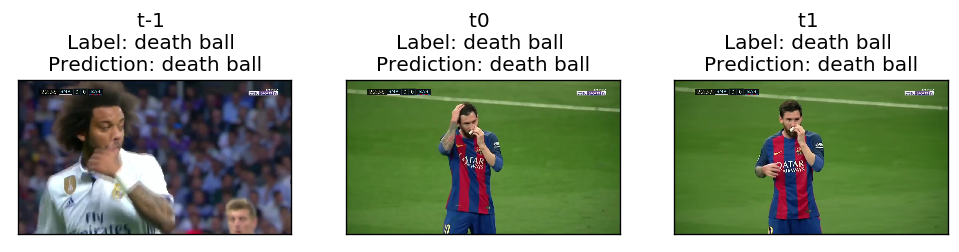

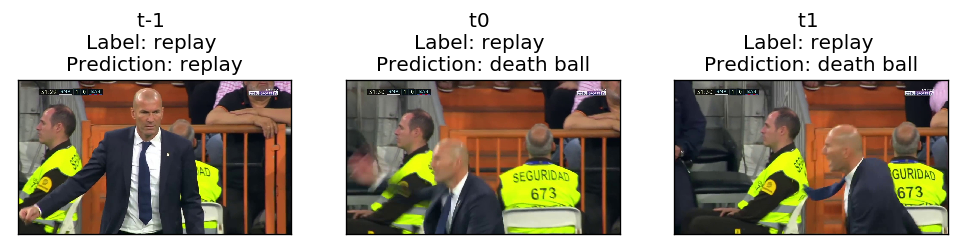

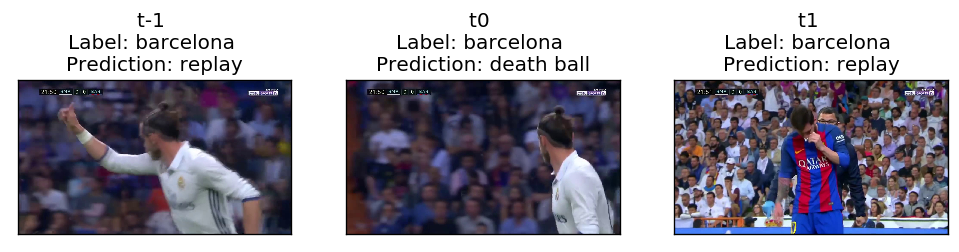

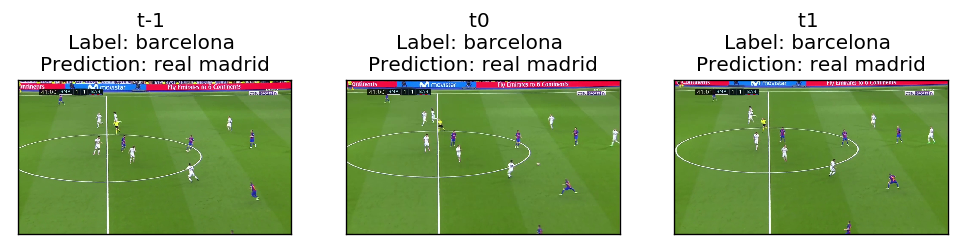

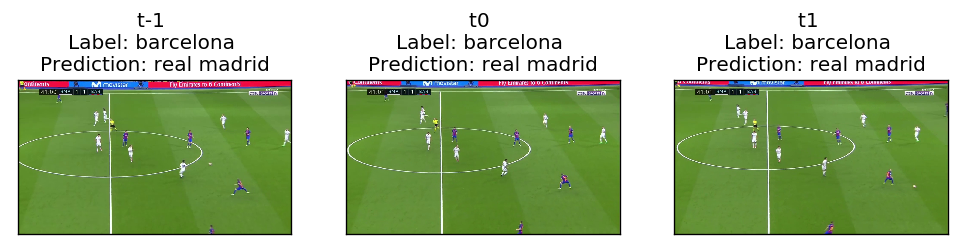

In [13]:
for index, row in uncertainity.iterrows():
    frame = row['frame']
    label = get_human_label(row['label'])
    prediction = get_human_label(row['pred_label'])
    
    fig, axes = plt.subplots(1, 3, figsize=(10,4), dpi=120)
    plt.gca().clear()
    
    i = 0
    for k in [-1, 0, 1]:
        frame_ = frame + 10*k
        label = get_human_label(list(predictions['label'][predictions['frame'] == frame_])[0])
        prediction = get_human_label(list(predictions['pred_label'][predictions['frame'] == frame_])[0])
        img_path = os.path.join("../ExtractFrames/", "clasico_frames/frame%s.jpg" % (frame_))
        axes[i].imshow(mpimg.imread(img_path))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title('t%d \nLabel: %s \nPrediction: %s' %(k, label, prediction))
        i += 1
    
    plt.show()      

We can notice that sometimes the algorithm guess correctly one or two of the images, but the other one is wrong. Right now the algorithm only considers a given image to guess the label, but seems like adding information from the previous or posteriors could be useful to improve the prediction.

## Interesting sequence

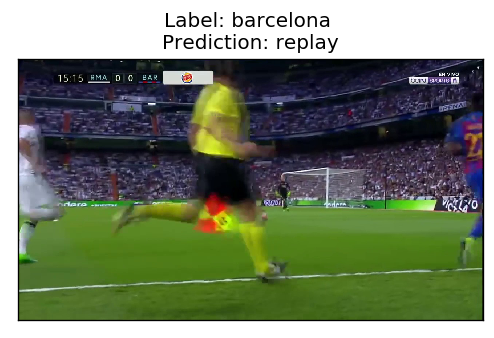

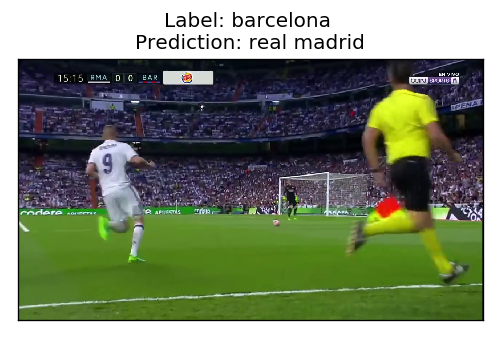

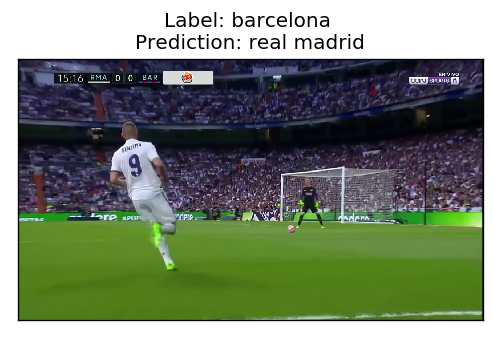

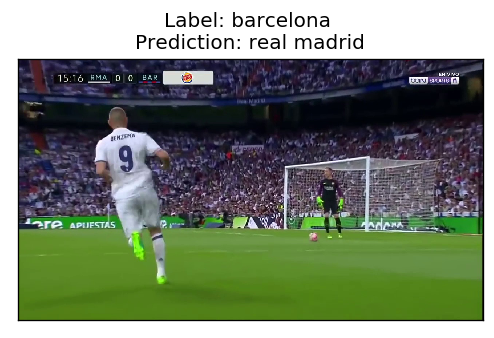

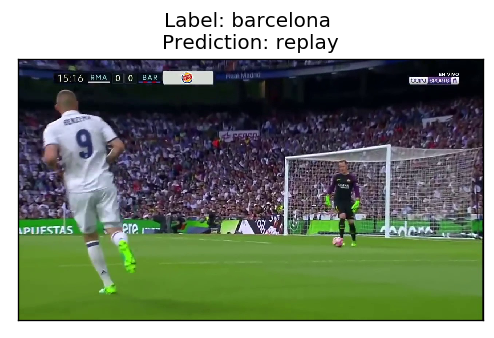

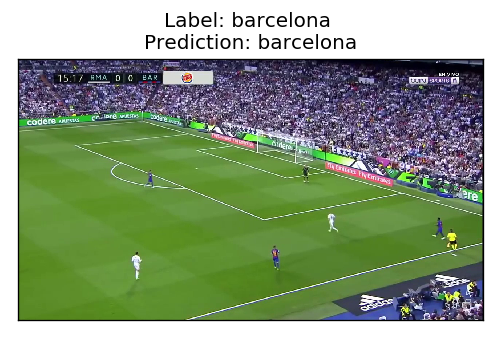

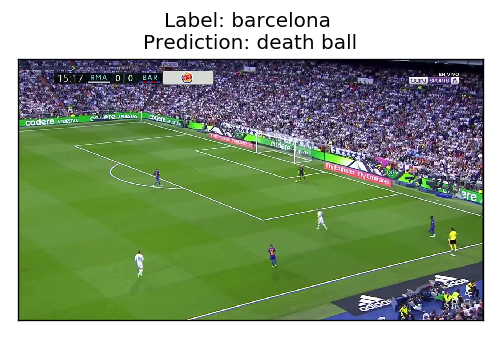

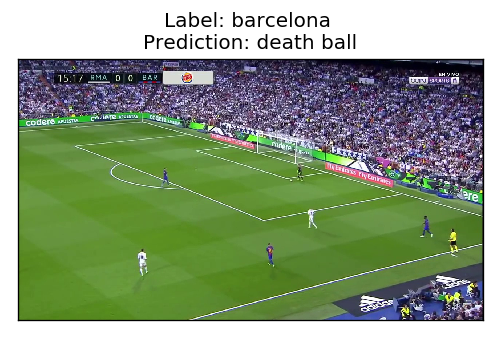

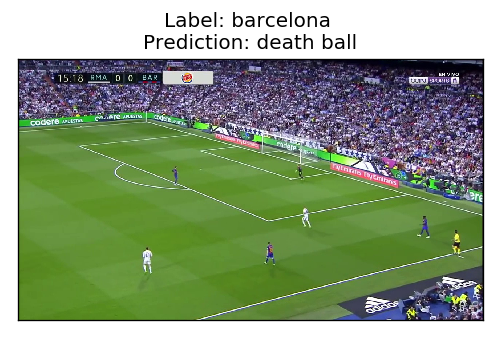

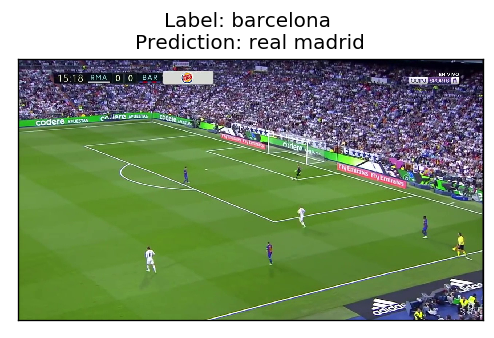

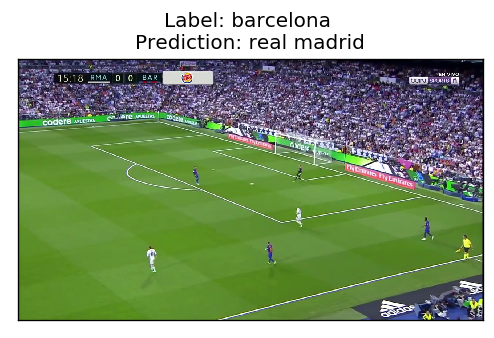

In [14]:
interesting_frames = np.arange(27690, 27800, 10)
      
for frame_ in interesting_frames:
    fig, axes = plt.subplots(figsize=(5,10), dpi=120)
    plt.gca().clear()
    label = get_human_label(list(predictions['label'][predictions['frame'] == frame_])[0])
    prediction = get_human_label(list(predictions['pred_label'][predictions['frame'] == frame_])[0])
    img_path = os.path.join("../ExtractFrames/", "clasico_frames/frame%s.jpg" % (frame_))
    plt.imshow(mpimg.imread(img_path))
    plt.xticks([])
    plt.yticks([])
    plt.title('Label: %s \nPrediction: %s' %(label, prediction))
    i += 1
    plt.show()   

In this sequence we can notice that Barcelona has ball possession in all of the eleven frames. However, the algorithm eventually assigns the four different labels during this short interval. **What if we can use the previous/posterior information to address this problem?**

One way to achieve that is by using **RNNs (_Recurrent Neural Networks_)**.